# Chest X-Ray Images (Pneumonia)
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Fetching our Data

In [0]:
! pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hod101s","key":"2513e0db9e548e9f93d1c5dda093eb71"}'}

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip --force

 99% 2.28G/2.29G [00:36<00:00, 96.3MB/s]
100% 2.29G/2.29G [00:36<00:00, 66.6MB/s]


In [0]:
TRAIN_PATH = "/content/chest_xray/train"
TEST_PATH = "/content/chest_xray/test"
VAL_PATH = "/content/chest_xray/val"
nrml = "NORMAL"
pneu = "PNEUMONIA"

### Viewing our data

In [0]:
def view(pth):
    images = list()
    for img in random.sample(os.listdir(pth),9):
        images.append(img)
    i = 0
    fig,ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
    for row in range(3):
        for col in range(3):
            ax[row,col].imshow(cv2.imread(os.path.join(pth,images[i])))
            i+=1

Pneumonia Images

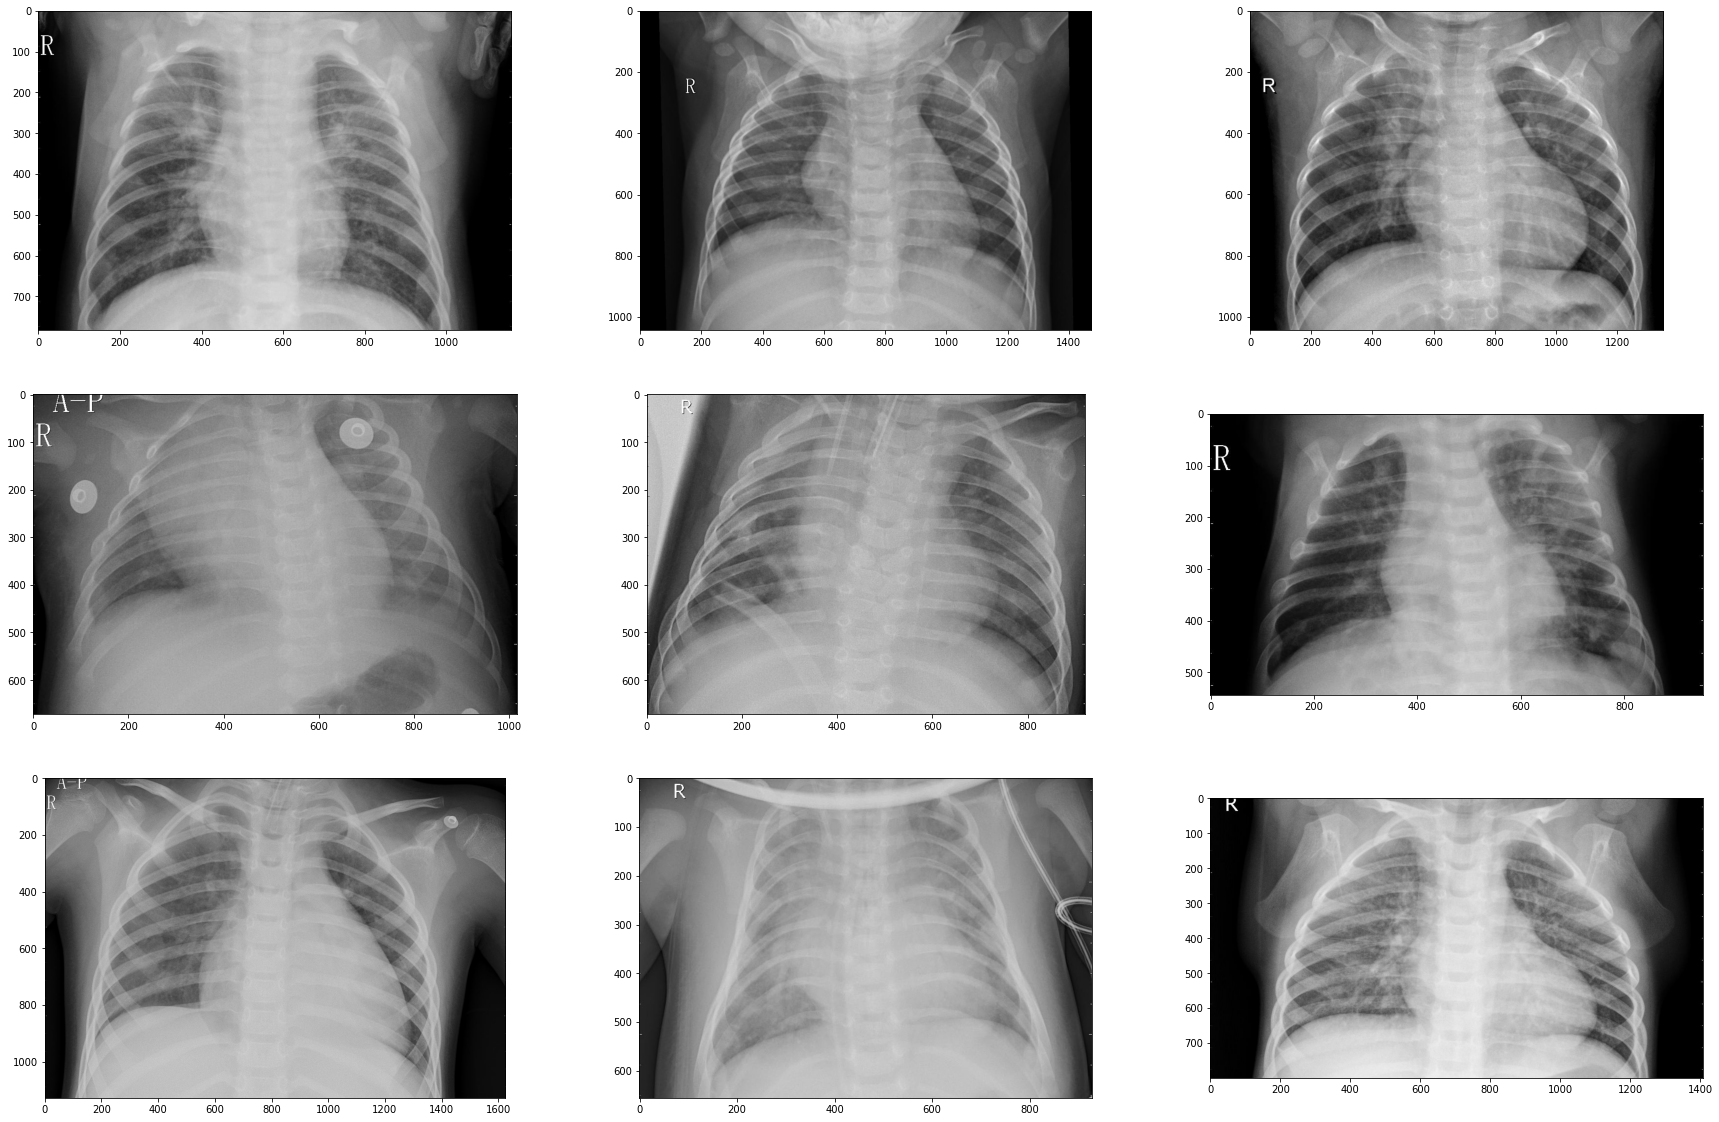

In [0]:
view(os.path.join(TRAIN_PATH,pneu))

Normal Images

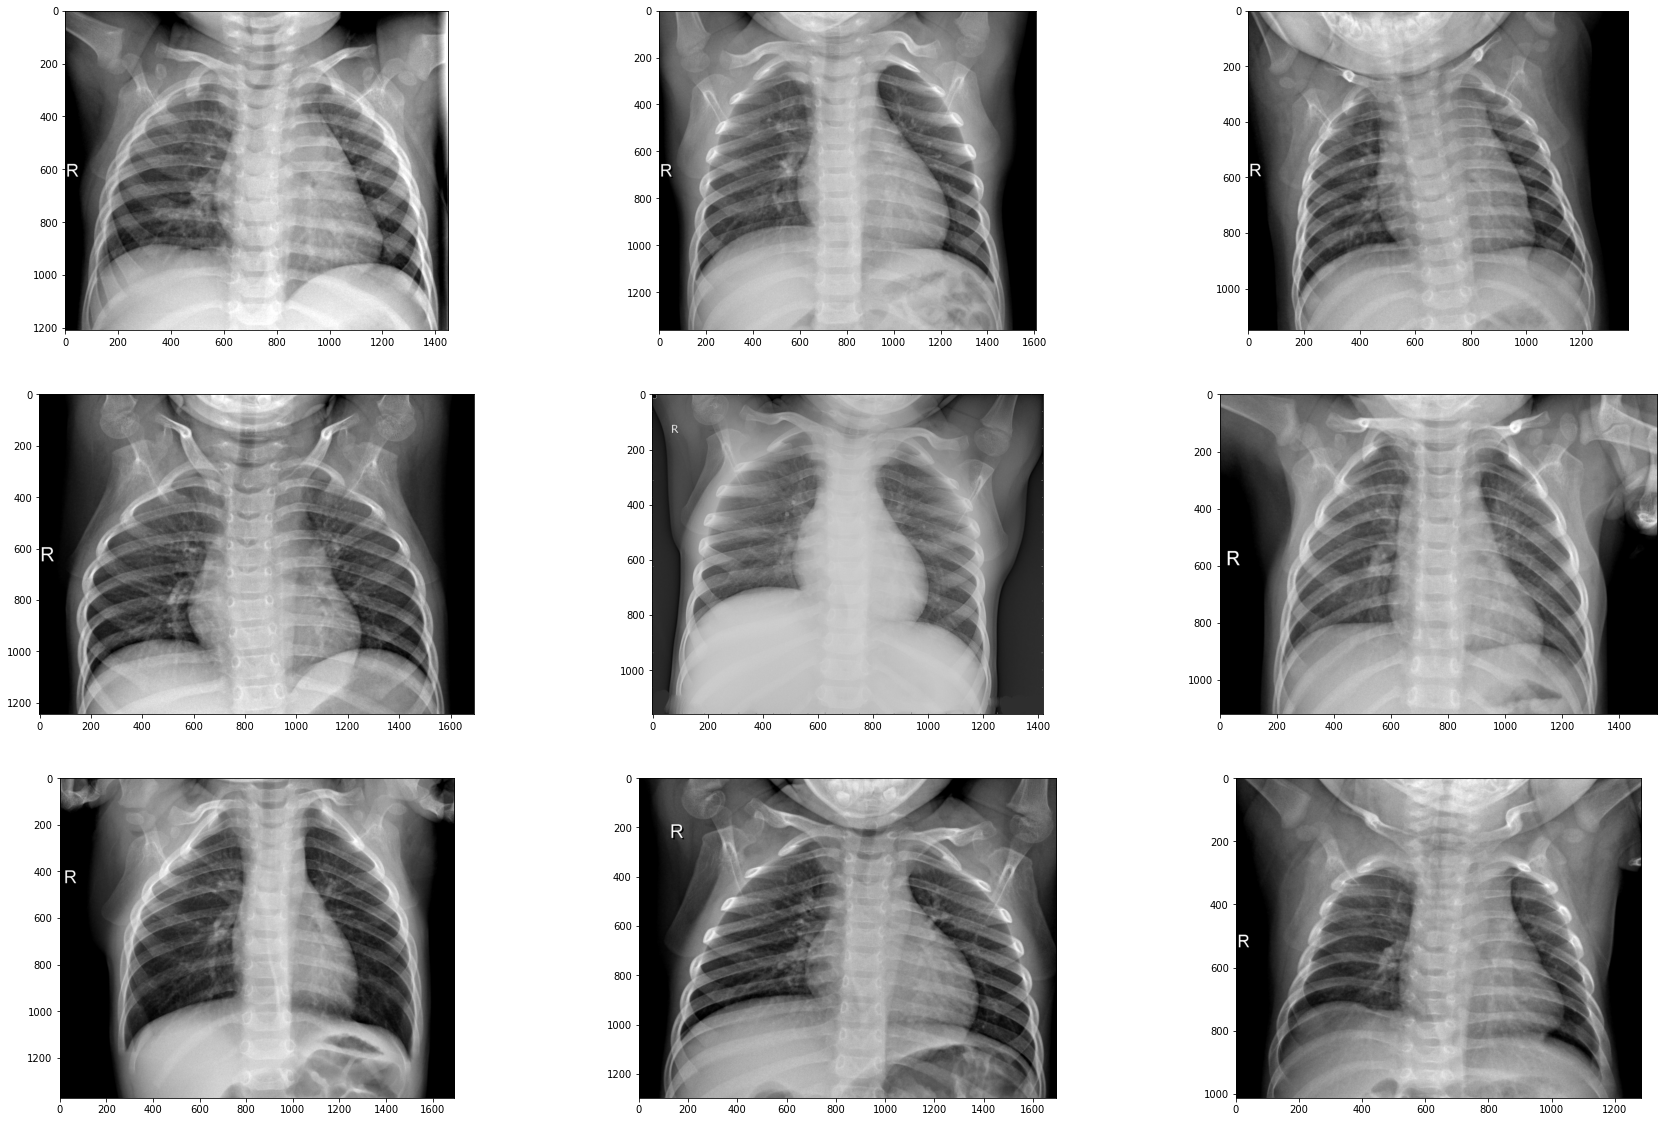

In [0]:
view(os.path.join(TRAIN_PATH,nrml))

Images do not seem to need any major pre-processing.

Test Data

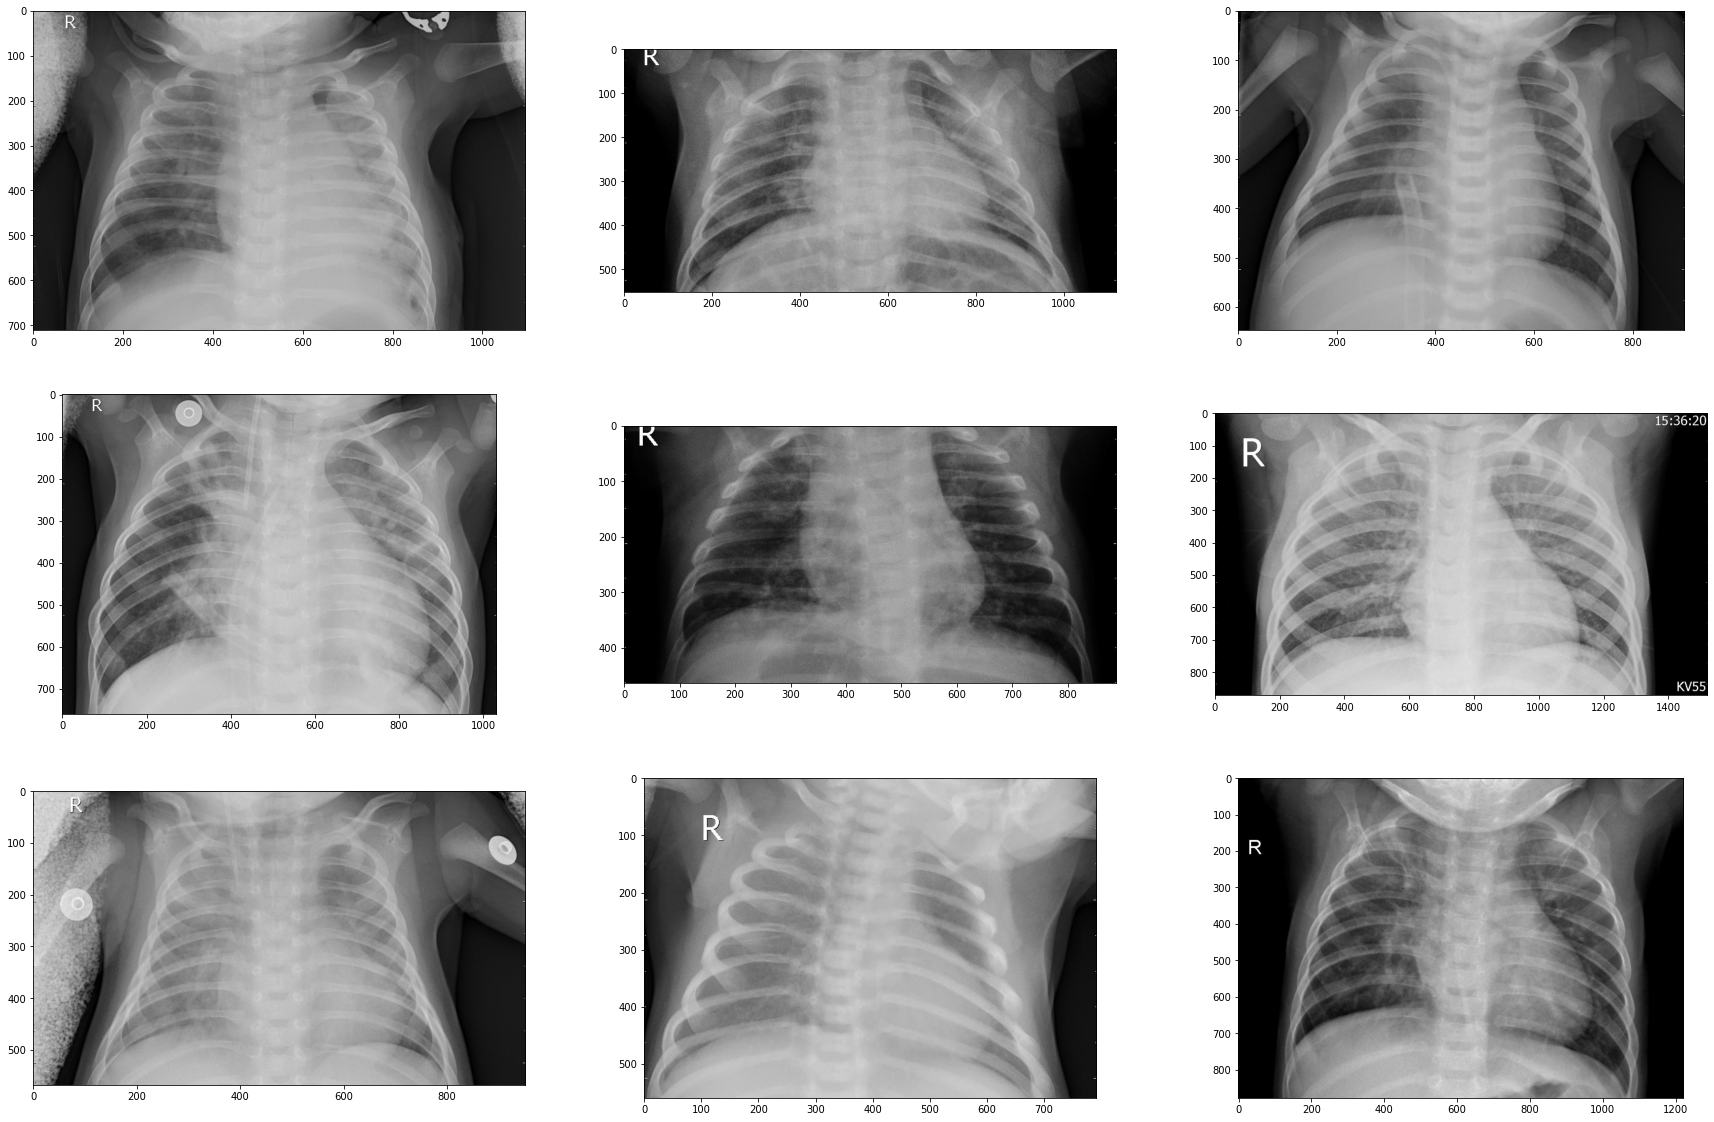

In [62]:
view(os.path.join(TEST_PATH,pneu))

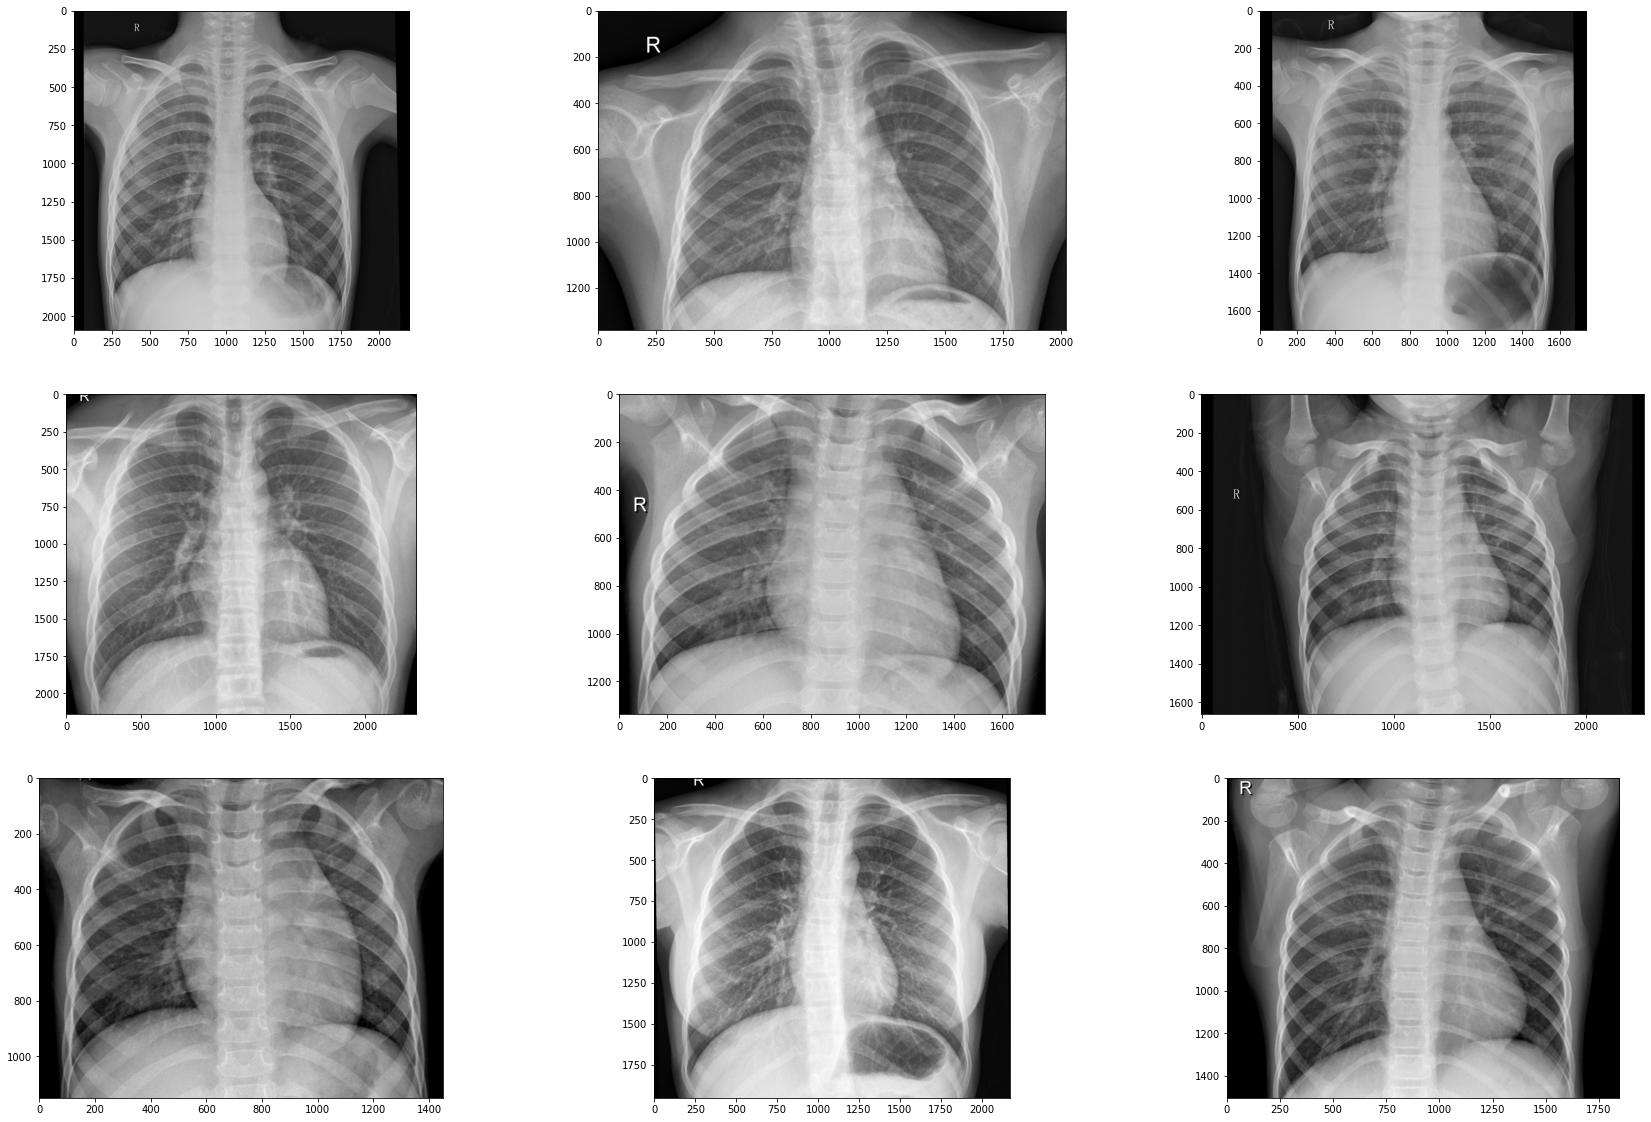

In [63]:
view(os.path.join(TEST_PATH,nrml))

## Understanding our Data

In [0]:
fig = go.Figure(go.Pie(labels=['Normal','Pneumonia'],values=[len(os.listdir(os.path.join(TRAIN_PATH,nrml))),len(os.listdir(os.path.join(TRAIN_PATH,pneu)))]))
fig.show()

Data is imbalanced. Accuracy will not be the best measure. Recall and precision results must be high.

## Data Pipelining and Aug

In [0]:
BATCH_SIZE = 32

In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3,VGG16,VGG19
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [0]:
datagen = ImageDataGenerator()

In [59]:
train_data = datagen.flow_from_directory(
    TRAIN_PATH,
    class_mode='categorical',
    shuffle = True,
    batch_size = BATCH_SIZE,
    target_size = (299,299)
)

Found 5216 images belonging to 2 classes.


In [60]:
val_data = datagen.flow_from_directory(
    VAL_PATH,
    class_mode='categorical',
    target_size = (299,299),
    batch_size = BATCH_SIZE
)

Found 16 images belonging to 2 classes.


### Helper Functions

In [0]:
def makeConMat(cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(pd.DataFrame(cm , index = ['Normal','Pneumonia'] , columns = ['Normal','Pneumonia']),cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',cbar=False)
    plt.show()

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Building our Model

### Working with InceptionV3 model

In [0]:
inceptionv3 = InceptionV3(weights='imagenet',include_top=False,input_shape=(299,299,3))

In [0]:
def getModel(transfer,train=False,addDNN = False):
    model = Sequential()
    model.add(transfer)
    model.add(GlobalAveragePooling2D())

    if addDNN:
        model.add(Dense(32,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(16,activation='relu'))
        model.add(Dropout(0.2))

    model.add(Dense(2,activation='softmax'))
    
    if not train:
        print('Not training Transferred Weights')
        model.layers[0].trainable = False
    model.summary()
    return model

In [237]:
model = getModel(inceptionv3,train=True,addDNN=True)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_41  (None, 2048)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 32)                65568     
_________________________________________________________________
dropout_69 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_70 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_121 (Dense)            (None, 2)               

In [0]:
model.compile(optimizer = Adam(learning_rate= 0.0001, decay=1e-5),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
es = EarlyStopping(
    monitor='val_acc',
    patience=5,
    verbose=1, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.1, 
    patience=10, 
    verbose=1, 
    mode='max'
)

checkpoint = ModelCheckpoint(
    'model 1.1', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

In [87]:
history = model.fit(
    train_data,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data = val_data,
    steps_per_epoch = 100,
    validation_steps = 16,
    callbacks = [checkpoint]
)

Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.2045 - acc: 0.9047
Epoch 00001: val_acc improved from -inf to 0.75000, saving model to model 1.1
INFO:tensorflow:Assets written to: model 1.1/assets
100/100 [==============================] - 174s 2s/step - loss: 0.2045 - acc: 0.9047 - val_loss: 0.6936 - val_acc: 0.7500
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.1118 - acc: 0.9459
Epoch 00002: val_acc did not improve from 0.75000
100/100 [==============================] - 104s 1s/step - loss: 0.1118 - acc: 0.9459 - val_loss: 1.0845 - val_acc: 0.6875
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.0713 - acc: 0.9709
Epoch 00003: val_acc improved from 0.75000 to 0.93750, saving model to model 1.1
INFO:tensorflow:Assets written to: model 1.1/assets
100/100 [==============================] - 173s 2s/step - loss: 0.0713 - acc: 0.9709 - val_loss: 0.1644 - val_acc: 0.9375
Epoch 4/20
100/100 [============================

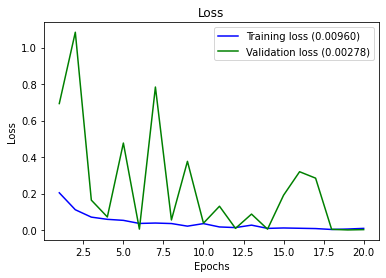

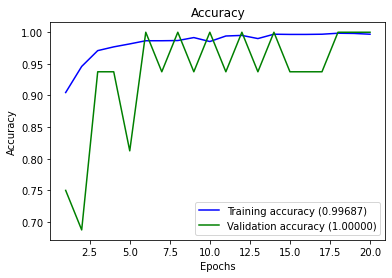

In [88]:
plot_history(history)

#### Predictions using Test Data

In [0]:
model = tf.keras.models.load_model('model 1.2')

In [253]:
test_data = datagen.flow_from_directory(
    TEST_PATH,
    class_mode='categorical',
    target_size = (299,299)
)

Found 624 images belonging to 2 classes.


In [254]:
results = model.evaluate(test_data,batch_size=BATCH_SIZE,steps=24,verbose=1)

24/24 [==============================] - 11s 442ms/step - loss: 1.6499 - acc: 0.8551


Model doesnt seem to generalise over test data very well.

In [255]:
pred = model.predict_generator(test_data,steps=624//BATCH_SIZE+1,verbose=1)

20/20 [==============================] - 8s 410ms/step


In [0]:
predictions = np.argmax(pred,axis=1)

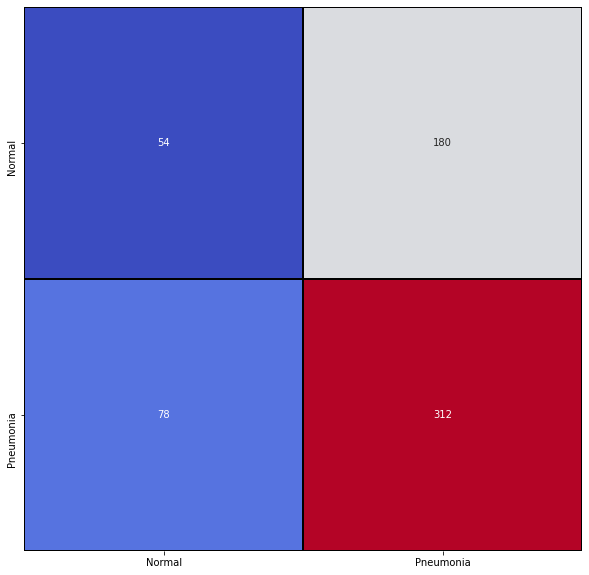

In [257]:
cm = confusion_matrix(test_data.classes,predictions)
makeConMat(cm)

In [258]:
print(classification_report(test_data.classes,predictions))

              precision    recall  f1-score   support

           0       0.41      0.23      0.30       234
           1       0.63      0.80      0.71       390

    accuracy                           0.59       624
   macro avg       0.52      0.52      0.50       624
weighted avg       0.55      0.59      0.55       624



#### Saving Model

In [122]:
tf.saved_model.save(model,'model 1.2')

INFO:tensorflow:Assets written to: model 1.2/assets


### Working with VGG16

In [0]:
vgg = VGG16(weights='imagenet',include_top=False,input_shape=(299,299,3))

In [245]:
modelv = getModel(vgg,train=False,addDNN=True)

Not training Transferred Weights
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_43  (None, 512)               0         
_________________________________________________________________
dense_125 (Dense)            (None, 32)                16416     
_________________________________________________________________
dropout_73 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_126 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_74 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_127 (Dense)   

In [0]:
modelv.compile(optimizer = Adam(learning_rate= 0.0001, decay=1e-5),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
es = EarlyStopping(
    monitor='val_acc',
    patience=8,
    verbose=1, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.1, 
    patience=10, 
    verbose=1, 
    mode='max'
)

checkpoint = ModelCheckpoint(
    'model 2.0', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

In [248]:
history = modelv.fit(
    train_data,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data = val_data,
    steps_per_epoch = 5216//BATCH_SIZE+1,
    validation_steps = 16,
    callbacks = [es,checkpoint]
)

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 0.6626 - acc: 0.7136
Epoch 00001: val_acc improved from -inf to 0.71169, saving model to model 2.0
INFO:tensorflow:Assets written to: model 2.0/assets
164/164 [==============================] - 110s 670ms/step - loss: 0.6626 - acc: 0.7136 - val_loss: 0.6735 - val_acc: 0.7117
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.4165 - acc: 0.8192
Epoch 00002: val_acc did not improve from 0.71169
164/164 [==============================] - 107s 652ms/step - loss: 0.4165 - acc: 0.8192 - val_loss: 0.7240 - val_acc: 0.6875
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.3039 - acc: 0.8761
Epoch 00003: val_acc improved from 0.71169 to 0.73185, saving model to model 2.0
INFO:tensorflow:Assets written to: model 2.0/assets
164/164 [==============================] - 111s 677ms/step - loss: 0.3039 - acc: 0.8761 - val_loss: 0.6875 - val_acc: 0.7319
Epoch 4/20
164/164 [===================

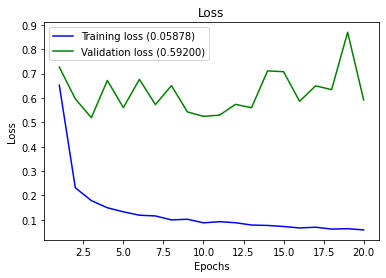

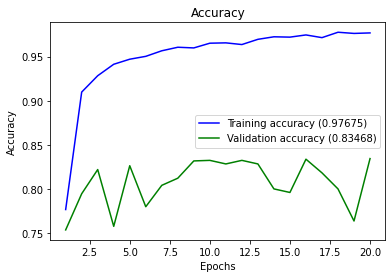

In [303]:
plot_history(history)

In [259]:
results = modelv.evaluate(test_data,batch_size=BATCH_SIZE,steps=24,verbose=1)

24/24 [==============================] - 13s 549ms/step - loss: 0.5973 - acc: 0.8019


In [260]:
pred = modelv.predict_generator(test_data,steps=624//BATCH_SIZE+1,verbose=1)

20/20 [==============================] - 12s 581ms/step


In [0]:
predictions = np.argmax(pred,axis=1)

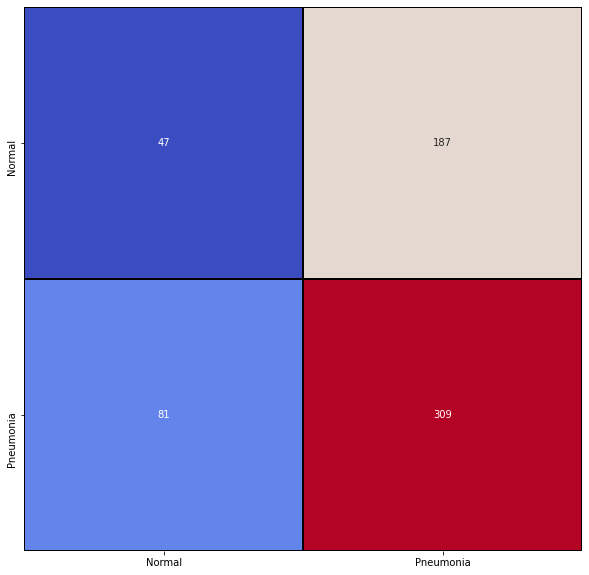

In [262]:
cm = confusion_matrix(test_data.classes,predictions)
makeConMat(cm)

In [263]:
print(classification_report(test_data.classes,predictions))

              precision    recall  f1-score   support

           0       0.37      0.20      0.26       234
           1       0.62      0.79      0.70       390

    accuracy                           0.57       624
   macro avg       0.50      0.50      0.48       624
weighted avg       0.53      0.57      0.53       624



Clearly, InceptionV3 model outperforms VGG16 model. 
Our model performs very well on train and validation data. On test data we manage to get 85% acc however recall and precision are low.

### VGG19

In [0]:
def getModel2(transfer):    
    model = Sequential()
    model.add(transfer)
    model.add(AveragePooling2D(pool_size=(3,3)))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.summary()
    return model

Lets change model Architecture. Our models so far have been overfitting training data.

In [0]:
datagen = ImageDataGenerator(horizontal_flip=True)

In [15]:
train_data2 = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(224,224),
    classes = ['NORMAL','PNEUMONIA'],
    class_mode = 'categorical',
    shuffle=True,
    batch_size = BATCH_SIZE
)

val_data2 = datagen.flow_from_directory(
    VAL_PATH,
    target_size=(224,224),
    classes = ['NORMAL','PNEUMONIA'],
    class_mode = 'categorical',
    batch_size = BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [0]:
vgg = VGG19(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg.trainable=False

In [32]:
mod19 = getModel2(vgg)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 20,286,914
Trainable params: 262,530
Non-trainable params: 20,024,384
____________________________________

In [0]:
mod19.compile(optimizer = Adam(learning_rate= 1e-2, decay=1e-5),loss='categorical_crossentropy',metrics=['acc'])

In [0]:
es = EarlyStopping(
    monitor='val_acc',
    patience=8,
    verbose=1, 
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.1, 
    patience=10, 
    verbose=1, 
    mode='max'
)

checkpoint = ModelCheckpoint(
    'model 3.0', 
    monitor='val_acc', 
    verbose=1, 
    save_best_only=True,
    mode='max'
)

In [35]:
history = mod19.fit(
    train_data2,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data = val_data2,
    steps_per_epoch = 5216//BATCH_SIZE+1,
    validation_steps = 16,
    callbacks = [es,reduce_lr,checkpoint]
)

Epoch 1/20
164/164 [==============================] - ETA: 0s - loss: 2.0036 - acc: 0.9251
Epoch 00001: val_acc improved from -inf to 0.90234, saving model to model 3.0
INFO:tensorflow:Assets written to: model 3.0/assets
164/164 [==============================] - 66s 404ms/step - loss: 2.0036 - acc: 0.9251 - val_loss: 0.1747 - val_acc: 0.9023 - lr: 0.0100
Epoch 2/20
164/164 [==============================] - ETA: 0s - loss: 0.0965 - acc: 0.9653
Epoch 00002: val_acc improved from 0.90234 to 0.94141, saving model to model 3.0
INFO:tensorflow:Assets written to: model 3.0/assets
164/164 [==============================] - 66s 401ms/step - loss: 0.0965 - acc: 0.9653 - val_loss: 0.2417 - val_acc: 0.9414 - lr: 0.0100
Epoch 3/20
164/164 [==============================] - ETA: 0s - loss: 0.0754 - acc: 0.9720
Epoch 00003: val_acc did not improve from 0.94141
164/164 [==============================] - 63s 381ms/step - loss: 0.0754 - acc: 0.9720 - val_loss: 0.3078 - val_acc: 0.8125 - lr: 0.0100
Epo

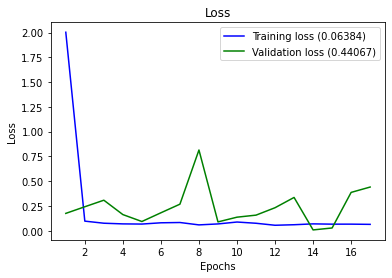

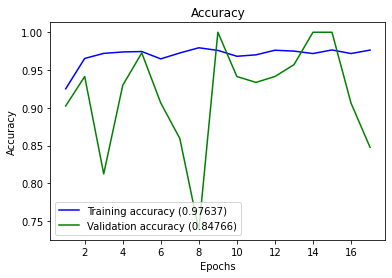

In [36]:
plot_history(history)

In [0]:
mod19_saved = tf.keras.models.load_model('model 3.0')

In [39]:
test_data2 = datagen.flow_from_directory(
    TEST_PATH,
    class_mode='categorical',
    target_size = (224,224)
)

Found 624 images belonging to 2 classes.


In [41]:
results = mod19_saved.evaluate(test_data2,batch_size=BATCH_SIZE,steps=24,verbose=1)

24/24 [==============================] - 7s 307ms/step - loss: 0.7578 - acc: 0.8059


In [42]:
pred = mod19_saved.predict_generator(test_data2,steps=624//BATCH_SIZE+1,verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
20/20 [==============================] - 6s 310ms/step


In [0]:
predictions = np.argmax(pred,axis=1)

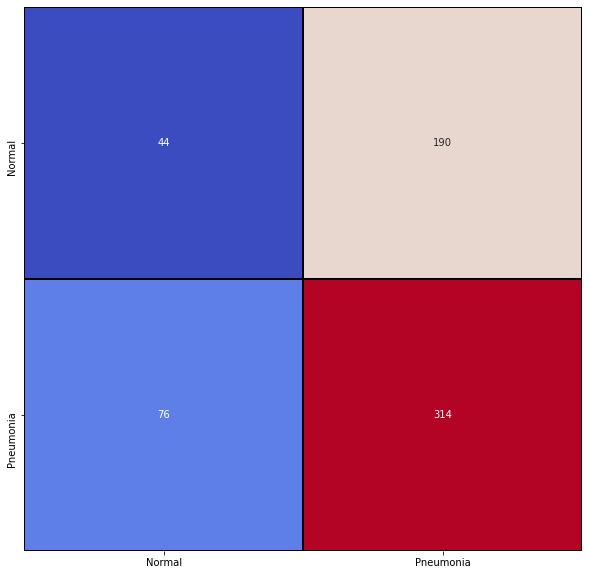

In [46]:
cm = confusion_matrix(test_data2.classes,predictions)
makeConMat(cm)

In [47]:
print(classification_report(test_data2.classes,predictions))

              precision    recall  f1-score   support

           0       0.37      0.19      0.25       234
           1       0.62      0.81      0.70       390

    accuracy                           0.57       624
   macro avg       0.49      0.50      0.48       624
weighted avg       0.53      0.57      0.53       624



By Far the InceptionV3 Model performed best. With a better balanced dataset we could acheive better results.